# Task 2

---

## Predictive modeling of customer bookings


### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline as ImbalancedPipeline
from sklearn.preprocessing import FunctionTransformer
import warnings
warnings.filterwarnings("ignore")

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [42]:
df = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking


In [75]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,1.000000,1.000000,1.000000,9.500000,1.000000


### Exploring Variables

Here the target variable is `booking_complete` and from the summary statistics it can be said that more than 75% of the data is 0 i.e "no booking", so exploring the variable `booking_complete` further

In [76]:
booking_count = df.booking_complete.value_counts()
print(booking_count)

0    42522
1     7478
Name: booking_complete, dtype: int64


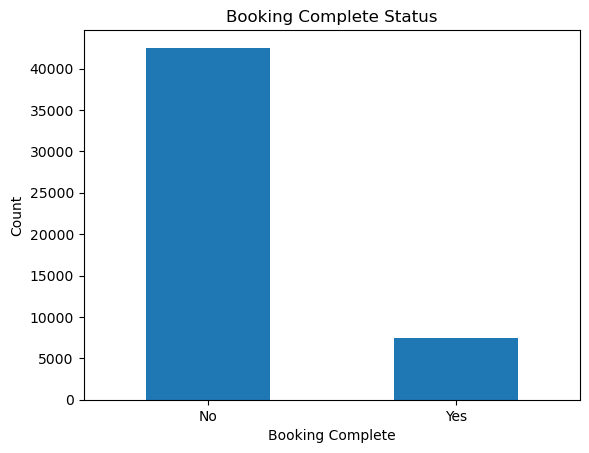

In [77]:
#mapping 0 with 'No' and 1 'with 'Yes' for better uderstanding of the graph
df.booking_complete.value_counts().rename({0: 'No', 1: 'Yes'}).plot(kind='bar')
plt.xlabel('Booking Complete')
plt.ylabel('Count')
plt.title('Booking Complete Status')
plt.xticks(rotation=0)
plt.show()

It is verified that the data is imbalanced

Checking the data for different countries specifically for the imbalance

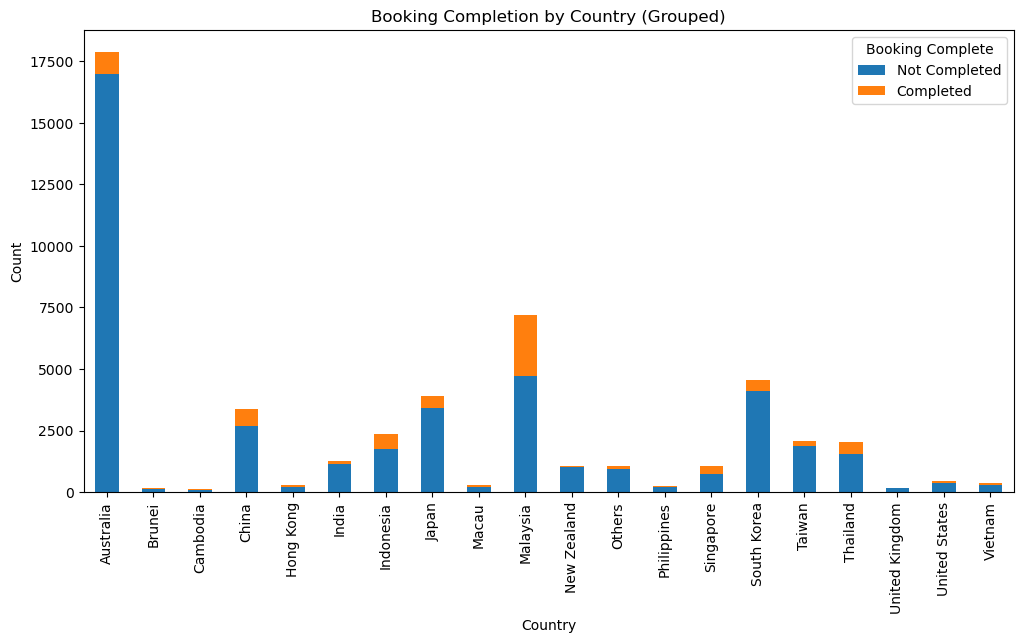

In [78]:
# Group the data by 'booking_origin' and calculate the count of 'booking_complete' values
df_viz = df.copy() # creating a copy for visualization
country_counts = df_viz['booking_origin'].value_counts()
other_countries = country_counts[country_counts < 100].index
df_viz['booking_origin_grouped'] = df_viz['booking_origin'].apply(lambda x: x if x not in other_countries else 'Others')

# Group by the 'booking_origin_grouped' column and 'booking_complete', then count
country_counts_grouped = df_viz.groupby('booking_origin_grouped')['booking_complete'].value_counts().unstack(fill_value=0)

# Create a bar chart
country_counts_grouped.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Booking Completion by Country (Grouped)')
plt.xlabel('Country')
plt.ylabel('Count')
plt.legend(title='Booking Complete', labels=['Not Completed', 'Completed'])

plt.show()

In this visualisation the countires with the occurances greater than 100 are plotted, from this we can come to a conclusion that for each country the possibility of successfuly making a booking is varying. There the imbalances of each country should be fixed individually.

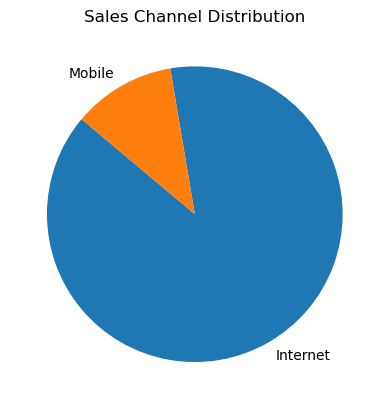

In [79]:
#Pie Chart for sales channel count
sales_channel_counts = df['sales_channel'].value_counts()
plt.pie(sales_channel_counts, labels=sales_channel_counts.index, startangle=140)
plt.title('Sales Channel Distribution')
# Display the chart
plt.show()

There are more `Interent` users than the `Mobile` platform users

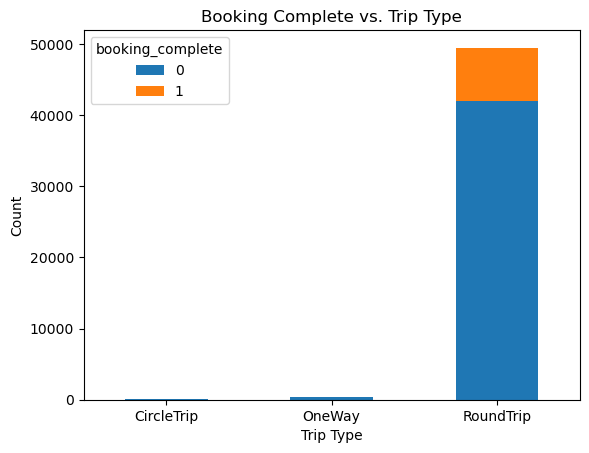

In [80]:
#Barplot for count proportion of each trip type that resulted in a booking completion 
df.groupby(['trip_type', 'booking_complete']).size().unstack().plot(kind='bar', stacked=True)
plt.xlabel('Trip Type')
plt.ylabel('Count')
plt.title('Booking Complete vs. Trip Type')
plt.xticks(rotation=0)
plt.show()

There are more number of people exploring `Round Trips` flights and more number of bookings for round trip as well 

### Feature Engineering: Dealing with categorical data 

#### Map encoding

In [10]:
#Starting by checking unique elements in flight_day
df['flight_day'].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [11]:
#Mapping flight days from 1 to 7 and then encoding the same to the dataframe
mapping_flight_day = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}


In [12]:
df['flight_day'].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [13]:
#Checkingf or unique elements in sales_channel
df['sales_channel'].unique() 

array(['Internet', 'Mobile'], dtype=object)

In [14]:
#Mapping internet with 1 and mobile with 2 and then encoding the same to the dataframe
mapping_sales_channel = {
    "Internet": 1,
    "Mobile": 2,
}


In [15]:
#Checking for types of trips
df['trip_type'].unique()

array(['RoundTrip', 'CircleTrip', 'OneWay'], dtype=object)

In [16]:
#Mapping the type of trips to 1 to and 3 and encoding them
mapping_trip_type = {
    "RoundTrip":1, 
    "CircleTrip":2, 
    "OneWay":3,
}

In [17]:
#Function for mapping and encoding categorical columns
def map_and_encode(df, column, mapping):
    df[column] = df[column].map(mapping)
    return df

In [44]:
#df = map_and_encode(df, 'flight_day', mapping_flight_day)
#df = map_and_encode(df, 'sales_channel', mapping_sales_channel)
#df = map_and_encode(df, 'trip_type', mapping_trip_type)
columns_to_encode = ['flight_day', 'sales_channel', 'trip_type']

# Perform one-hot encoding for the specified columns
df = pd.get_dummies(df, columns=columns_to_encode)


In [6]:
#Checking for number of unique routes
len(df['route'].unique())

799

In [83]:
#Checking for number of unique booking_origin
len(df['booking_origin'].unique())

104

The features `flight_day`, `sales_channel` and `trip_type` have a very few number of unique categorical values , so mapping is feasible. But for `route` and `booking_origin` this is not possible. Therefore making use of target encoding to encode `route` and `booking_origin`.

#### Target encoding

encoder = TargetEncoder()
df['route'] = encoder.fit_transform(df['route'], df['booking_complete'])
df['booking_origin'] = encoder.fit_transform(df['booking_origin'], df['booking_complete'])

In [45]:
import category_encoders as ce
# Initialize the BinaryEncoder
encoder = ce.CountEncoder(cols=['route', 'booking_origin'])

# Perform binary encoding
df = encoder.fit_transform(df)

In [46]:
#Data after encoding
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,...,flight_day_Sat,flight_day_Sun,flight_day_Thu,flight_day_Tue,flight_day_Wed,sales_channel_Internet,sales_channel_Mobile,trip_type_CircleTrip,trip_type_OneWay,trip_type_RoundTrip
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,404.939120,8737.094720,0.668780,0.296960,0.427140,7.277561,...,0.116240,0.131080,0.148480,0.153460,0.153480,0.887640,0.112360,0.002320,0.007740,0.989940
std,1.020165,90.451378,33.88767,5.41266,591.782184,7054.684827,0.470657,0.456923,0.494668,1.496863,...,0.320516,0.337491,0.355579,0.360434,0.360453,0.315812,0.315812,0.048111,0.087637,0.099795
min,1.000000,0.000000,0.00000,0.00000,1.000000,1.000000,0.000000,0.000000,0.000000,4.670000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,81.000000,2369.000000,0.000000,0.000000,0.000000,5.620000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,51.000000,17.00000,9.00000,227.000000,7174.000000,1.000000,0.000000,0.000000,7.570000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,2.000000,115.000000,28.00000,13.00000,465.000000,17872.000000,1.000000,1.000000,1.000000,8.830000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,9.000000,867.000000,778.00000,23.00000,2680.000000,17872.000000,1.000000,1.000000,1.000000,9.500000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   num_passengers          50000 non-null  int64  
 1   purchase_lead           50000 non-null  int64  
 2   length_of_stay          50000 non-null  int64  
 3   flight_hour             50000 non-null  int64  
 4   route                   50000 non-null  int64  
 5   booking_origin          50000 non-null  int64  
 6   wants_extra_baggage     50000 non-null  int64  
 7   wants_preferred_seat    50000 non-null  int64  
 8   wants_in_flight_meals   50000 non-null  int64  
 9   flight_duration         50000 non-null  float64
 10  booking_complete        50000 non-null  int64  
 11  flight_day_Fri          50000 non-null  uint8  
 12  flight_day_Mon          50000 non-null  uint8  
 13  flight_day_Sat          50000 non-null  uint8  
 14  flight_day_Sun          50000 non-null

### Checking the relationship between the variables

In [14]:
#checking for outliers
# Calculate Q1 and Q3
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = ((df < lower_bound) | (df > upper_bound)).any(axis=1)

# Print or manipulate the rows containing outliers
print(df[outliers])

       num_passengers  purchase_lead  length_of_stay  flight_hour  route_0  \
0                   2            262              19            7        0   
1                   1            112              20            3        0   
2                   2            243              22           17        0   
3                   1             96              31            4        0   
4                   2             68              22           15        0   
...               ...            ...             ...          ...      ...   
49995               2             27               6            9        1   
49996               1            111               6            4        1   
49997               1             24               6           22        1   
49998               1             15               6           11        1   
49999               1             19               6           10        1   

       route_1  route_2  route_3  route_4  route_5  ...  flight

There are a significant number of outliers in the data

In [15]:
#Checking for linear relationship between variables using regression analysis
features = df.drop('booking_complete', axis=1) 
# Create a linear regression model
model = LinearRegression()
model.fit(features, df['booking_complete'])

LinearRegression()

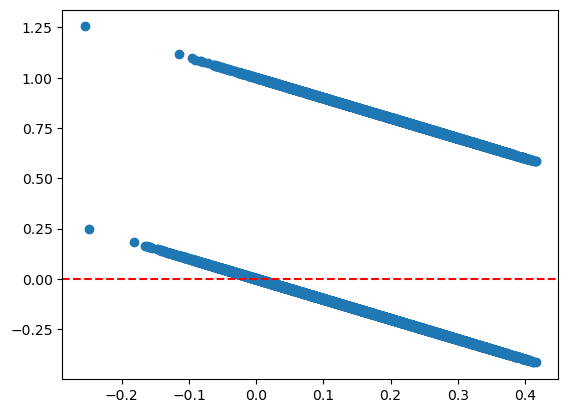

In [16]:
predicted = model.predict(features)
residuals = df['booking_complete'] - predicted
plt.scatter(predicted, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

This plot of predicted vs residuals signifies that the variables don't have a linear relationship, therefore `Spearmann's Rank Correlation` is used to calcualte the correlation between the variables 

In [48]:
#checking correlation
corr = df.corr(method='spearman')
corr

,num_passengers,purchase_lead,length_of_stay,flight_hour,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,...,flight_day_Sat,flight_day_Sun,flight_day_Thu,flight_day_Tue,flight_day_Wed,sales_channel_Internet,sales_channel_Mobile,trip_type_CircleTrip,trip_type_OneWay,trip_type_RoundTrip
num_passengers,1.000000,0.253983,-0.125389,0.024562,0.005743,-0.071964,0.131922,0.047646,0.020788,-0.059025,...,0.010084,0.032267,-0.007318,-0.013174,-0.005776,0.003290,-0.003290,0.001922,-0.004742,0.003238
purchase_lead,0.253983,1.000000,0.024810,0.043673,0.058186,-0.025420,0.016768,0.008763,-0.000309,0.078954,...,0.009720,0.097173,-0.032106,-0.017147,-0.044985,0.016415,-0.016415,0.009097,0.010200,-0.013343
length_of_stay,-0.125389,0.024810,1.000000,-0.047602,0.021819,0.216945,0.284546,0.025141,0.128857,0.234792,...,0.005241,-0.005193,0.001032,-0.005604,-0.001866,0.082412,-0.082412,0.003994,-0.019126,0.014870
flight_hour,0.024562,0.043673,-0.047602,1.000000,0.002255,-0.082190,-0.010128,0.009928,0.012159,-0.023922,...,-0.007482,0.046721,-0.004923,-0.003307,-0.004154,-0.022843,0.022843,-0.000121,0.004523,-0.003914
route,0.005743,0.058186,0.021819,0.002255,1.000000,0.064670,0.017855,-0.001854,0.005332,0.214550,...,-0.001161,0.014558,-0.009244,0.007695,-0.001681,0.020356,-0.020356,-0.020797,-0.014136,0.022440
booking_origin,-0.071964,-0.025420,0.216945,-0.082190,0.064670,1.000000,0.057695,0.076618,0.111667,0.275182,...,-0.006480,-0.009199,0.015709,-0.005634,0.010121,0.059485,-0.059485,0.017537,-0.006612,-0.002648
wants_extra_baggage,0.131922,0.016768,0.284546,-0.010128,0.017855,0.057695,1.000000,0.207669,0.216470,0.062105,...,0.003719,-0.008333,0.002746,0.004651,0.003393,0.054254,-0.054254,0.011855,0.007847,-0.012606
wants_preferred_seat,0.047646,0.008763,0.025141,0.009928,-0.001854,0.076618,0.207669,1.000000,0.315088,0.093661,...,0.008203,0.007357,-0.009310,-0.011850,0.003902,-0.032943,0.032943,-0.000407,-0.007953,0.007181
wants_in_flight_meals,0.020788,-0.000309,0.128857,0.012159,0.005332,0.111667,0.216470,0.315088,1.000000,0.148469,...,0.004095,0.002698,0.003856,-0.008351,-0.002229,0.022235,-0.022235,-0.002982,-0.014442,0.014120
flight_duration,-0.059025,0.078954,0.234792,-0.023922,0.214550,0.275182,0.062105,0.093661,0.148469,1.000000,...,0.004066,0.024004,-0.006385,-0.004473,-0.002791,0.042672,-0.042672,0.015446,0.038319,-0.041097


<Axes: >

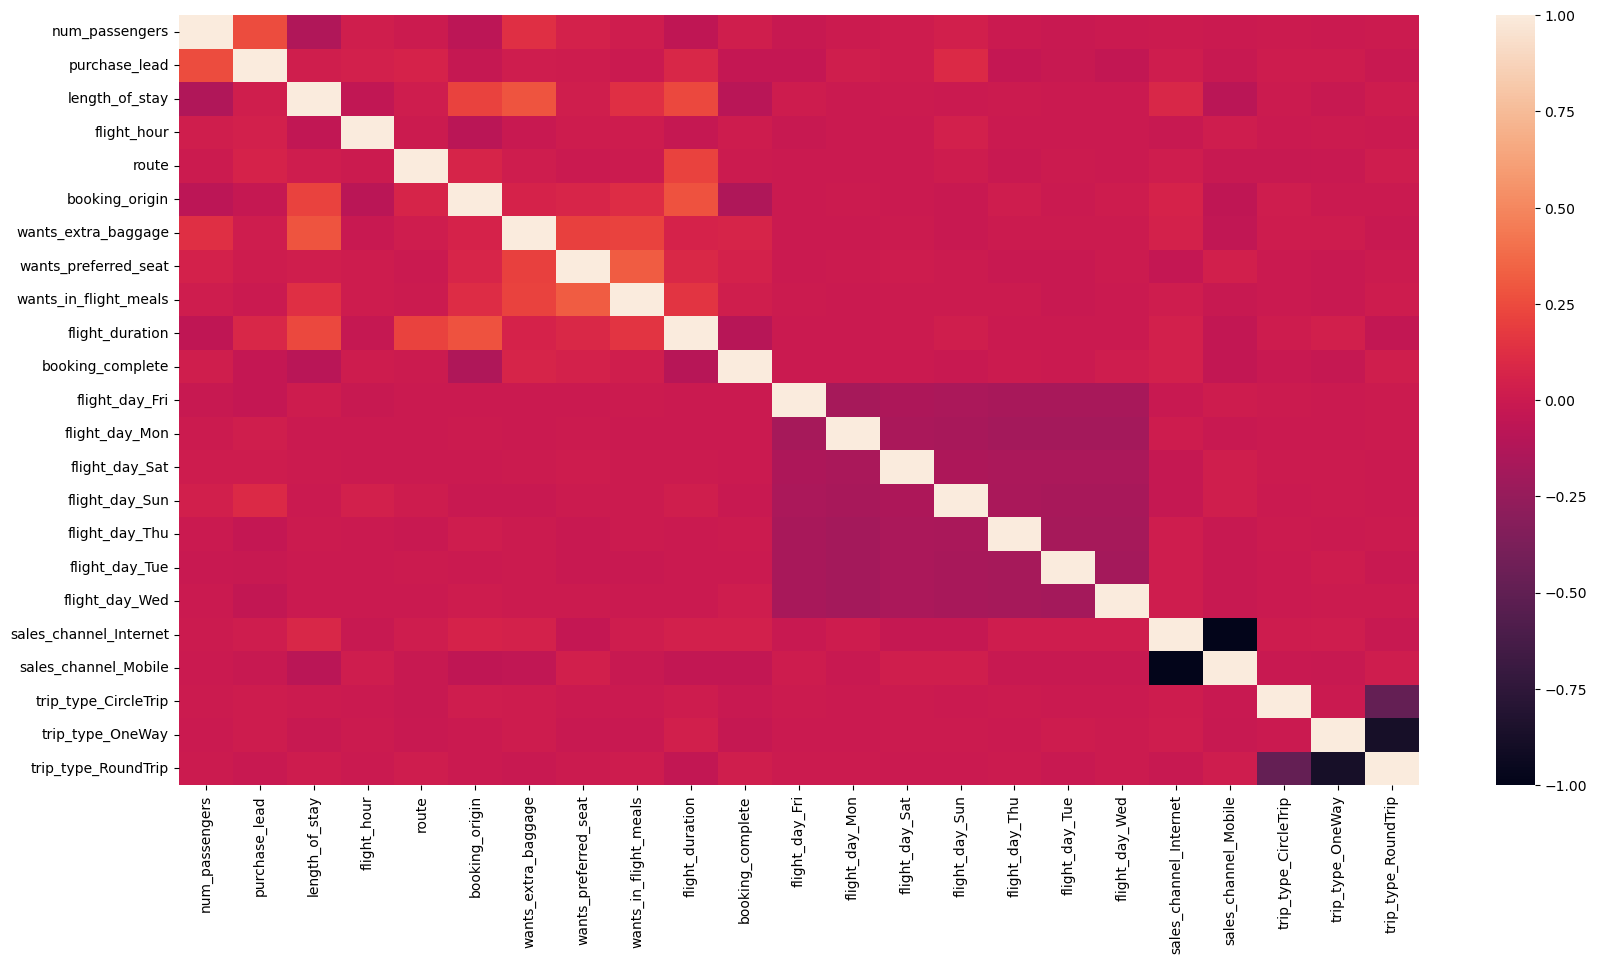

In [49]:
plt.figure(figsize=(20,10))
sns.heatmap(corr)

In [50]:
#Correlated freatures w.r.t booking_complete in descending order (absolute corr values are considerd)
corr['booking_complete'].abs().sort_values(ascending=False)

booking_complete          1.000000
booking_origin            0.133312
flight_duration           0.097633
length_of_stay            0.086417
wants_extra_baggage       0.068139
wants_preferred_seat      0.050116
sales_channel_Mobile      0.041060
sales_channel_Internet    0.041060
purchase_lead             0.033870
trip_type_RoundTrip       0.028226
num_passengers            0.027619
wants_in_flight_meals     0.026511
trip_type_OneWay          0.024240
flight_day_Wed            0.016223
trip_type_CircleTrip      0.014394
flight_hour               0.013091
flight_day_Sun            0.008843
route                     0.007093
flight_day_Fri            0.004621
flight_day_Tue            0.002890
flight_day_Thu            0.001840
flight_day_Sat            0.001442
flight_day_Mon            0.001177
Name: booking_complete, dtype: float64

In [51]:
#Mutual Information of variables w.r.t booking_complete
mi_scores = mutual_info_classif(features, df['booking_complete'])
mi_scores = pd.Series(mi_scores, name="MI Scores", index=features.columns)
mi_scores = mi_scores.sort_values(ascending=False)

mi_scores

booking_origin_1          0.026978
booking_origin_5          0.020959
flight_duration           0.017598
length_of_stay            0.009444
booking_origin_4          0.008983
booking_origin_6          0.008893
wants_extra_baggage       0.008811
trip_type_RoundTrip       0.008568
route_4                   0.008063
sales_channel_Internet    0.006975
route_3                   0.006959
route_8                   0.006659
route_7                   0.006478
route_9                   0.006359
wants_in_flight_meals     0.006068
route_1                   0.005398
wants_preferred_seat      0.004043
route_6                   0.003923
booking_origin_3          0.003484
sales_channel_Mobile      0.003124
purchase_lead             0.002724
num_passengers            0.002581
flight_day_Mon            0.002569
route_5                   0.002408
route_0                   0.002266
flight_hour               0.001404
flight_day_Wed            0.000992
flight_day_Sun            0.000951
trip_type_OneWay    

Comparing the cofficient sores and mutual information sores the best features could be:

`route`,    
`booking_origin`          
`flight_duration`          
`length_of_stay`           
`sales_channel`               
`trip_type`                
`wants_preferred_seat`    
`purchase_lead`

### Partitioning the data

In [52]:
X = df.drop('booking_complete', axis=1)
y = df['booking_complete']

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 42)

In [54]:
#feature selection columns to remove
columns_to_remove = ['wants_in_flight_meals','num_passengers','wants_extra_baggage']

#wants_extra_baggage and length of stay, as well as num_passengers and purchase_lead are highly correlated

In [55]:
#Function to remove unwanted columns
def feature_selection(X, columns_to_remove):
    return X.drop(columns=columns_to_remove, axis=1)


In [56]:
#Custom transformer using Function Transformer
feature_selection_transformer = FunctionTransformer(func=feature_selection, kw_args={"columns_to_remove": columns_to_remove})

### Resampling Data

Resampling the train data using `SMOTE-Tomek` link technique, it is ideal in this situation because this technique will combine over and undersampling as well as clean the resampled data using tomek link

In [57]:
#Function for resampling the data
def resample_data(X_train, y_train, min_samples_threshold=100):
    distinct_origin = X_train['booking_origin'].unique()
    resampled_X_train = []
    resampled_y_train = []

    for origin in distinct_origin:
        X_origin = X_train[X_train['booking_origin'] == origin]
        y_origin = y_train[X_train['booking_origin'] == origin]

        if len(y_origin) < min_samples_threshold:
            resampled_X_train.append(X_origin)
            resampled_y_train.append(y_origin)
        else:
            smt = SMOTETomek(sampling_strategy='auto', random_state=42)
            X_resampled, y_resampled = smt.fit_resample(X_origin, y_origin)
            resampled_X_train.append(X_resampled)
            resampled_y_train.append(y_resampled)

    X_train_resampled = pd.concat(resampled_X_train, axis=0)
    y_train_resampled = pd.concat(resampled_y_train, axis=0)

    return X_train_resampled, y_train_resampled


In [58]:
#Applying resampling on the data
X_train_resampled, y_train_resampled = resample_data(X_train, y_train)

In [29]:
smt = SMOTETomek(sampling_strategy='auto', random_state=42)
#Applying resampling on the data
X_train_resampled, y_train_resampled = smt.fit_resample(X_train, y_train)

In [59]:
#Before resampling
y_train.value_counts()

0    29765
1     5235
Name: booking_complete, dtype: int64

In [60]:
#After resampling
y_train_resampled.value_counts()

0    28535
1    27939
Name: booking_complete, dtype: int64

### Model Building

#### Random Forest Classifier

##### Without feature selection

In [61]:
#Model pipeline for Random Forest without feature selection
rf_model = RandomForestClassifier(random_state=32)
model_pipeline_rf = ImbalancedPipeline([
    ('Scaling', StandardScaler()),
    ('model', rf_model)
])

In [62]:
target_names=['Uncompleted_Booking','Completed_Booking']

In [63]:
#Building and evaluating Random Forest model
model_pipeline_rf.fit(X_train_resampled, y_train_resampled)
y_pred_rf = model_pipeline_rf.predict(X_test)
report_rf = classification_report(y_test, y_pred_rf, target_names=target_names)

In [64]:
print(report_rf)

                     precision    recall  f1-score   support

Uncompleted_Booking       0.86      0.98      0.92     12757
  Completed_Booking       0.44      0.08      0.13      2243

           accuracy                           0.85     15000
          macro avg       0.65      0.53      0.53     15000
       weighted avg       0.80      0.85      0.80     15000



##### With feature selection

In [65]:
#Model pipeline for Random Forest with feature selection
rf_model = RandomForestClassifier(random_state=32)
model_pipeline_rf_fs = ImbalancedPipeline([
    ('feature_selection', feature_selection_transformer),
    ('Scaling', StandardScaler()),
    ('model', rf_model)
])

In [66]:
#Building and evaluating Random Forest model
model_pipeline_rf_fs.fit(X_train_resampled, y_train_resampled)
y_pred_rf_fs = model_pipeline_rf_fs.predict(X_test)
report_rf_fs = classification_report(y_test, y_pred_rf_fs, target_names=target_names)

In [67]:
print(report_rf_fs)

                     precision    recall  f1-score   support

Uncompleted_Booking       0.86      0.97      0.91     12757
  Completed_Booking       0.41      0.10      0.17      2243

           accuracy                           0.84     15000
          macro avg       0.64      0.54      0.54     15000
       weighted avg       0.79      0.84      0.80     15000



#### XGBoost Classifier

##### Without feature selection

In [68]:
#Model pipeline for XGBoost without feature selection
xgb_model = XGBClassifier()
model_pipeline_xgb = ImbalancedPipeline([
    ('Scaling', StandardScaler()),
    ('model', xgb_model)
])


In [69]:
#Building and evaluating XGBoost models
model_pipeline_xgb.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = model_pipeline_xgb.predict(X_test)
report_xgb = classification_report(y_test, y_pred_xgb, target_names=target_names)

In [70]:
print(report_xgb)

                     precision    recall  f1-score   support

Uncompleted_Booking       0.87      0.96      0.91     12757
  Completed_Booking       0.40      0.15      0.22      2243

           accuracy                           0.84     15000
          macro avg       0.64      0.56      0.57     15000
       weighted avg       0.80      0.84      0.81     15000



##### With feature selection

In [71]:
#Model pipeline for XGBoost with feature selection
xgb_model_fs = XGBClassifier()
model_pipeline_xgb_fs = ImbalancedPipeline([
    ('feature_selection', feature_selection_transformer),
    ('Scaling', StandardScaler()),
    ('model', xgb_model_fs)
])

In [72]:
#Building and evaluating XGBoost models
model_pipeline_xgb_fs.fit(X_train_resampled, y_train_resampled)
y_pred_xgb_fs = model_pipeline_xgb_fs.predict(X_test)
report_xgb_fs = classification_report(y_test, y_pred_xgb_fs, target_names=target_names)

In [73]:
print(report_xgb_fs)

                     precision    recall  f1-score   support

Uncompleted_Booking       0.86      0.96      0.91     12757
  Completed_Booking       0.39      0.14      0.20      2243

           accuracy                           0.84     15000
          macro avg       0.63      0.55      0.56     15000
       weighted avg       0.79      0.84      0.80     15000



#### AdaBoost

##### Without feature selection

In [126]:
#Model pipeline for AdaBoost with feature selection
ada_model = AdaBoostClassifier()
model_pipeline_ada = ImbalancedPipeline([
    ('Scaling', StandardScaler()),
    ('model', ada_model)
])

In [127]:
# Build and evaluate AdaBoost models
model_pipeline_ada.fit(X_train_resampled, y_train_resampled)
y_pred_ada = model_pipeline_ada.predict(X_test)
report_ada = classification_report(y_test, y_pred_ada, target_names=target_names)

In [128]:
print(report_ada)

                     precision    recall  f1-score   support

  Completed_Booking       0.87      0.93      0.90     12757
Uncompleted_Booking       0.37      0.23      0.29      2243

           accuracy                           0.83     15000
          macro avg       0.62      0.58      0.59     15000
       weighted avg       0.80      0.83      0.81     15000



##### With feature selection

In [129]:
# Define a model pipeline for AdaBoost with feature selection
ada_model_fs = AdaBoostClassifier()
model_pipeline_ada_fs = ImbalancedPipeline([
    ('feature_selection', feature_selection_transformer),
    ('Scaling', StandardScaler()),
    ('model', ada_model_fs)
])

In [130]:
model_pipeline_ada_fs.fit(X_train_resampled, y_train_resampled)
y_pred_ada_fs = model_pipeline_ada_fs.predict(X_test)
report_ada_fs = classification_report(y_test, y_pred_ada_fs, target_names=target_names)

In [131]:
print(report_ada_fs)

                     precision    recall  f1-score   support

  Completed_Booking       0.87      0.93      0.90     12757
Uncompleted_Booking       0.38      0.23      0.29      2243

           accuracy                           0.83     15000
          macro avg       0.63      0.58      0.59     15000
       weighted avg       0.80      0.83      0.81     15000



##### Result

Since the data is imbalanced and since resampled taking Accuracy as part of model evaluation term is not correct so taking precision recall and F1 scores in consideration, `Random Forest` model with `feature selection` performs the best. 

For Completed_Booking category the model prediction is having a precision of 0.88, recall of 0.91 and F1 score of 0.89.
For Uncompleted_Booking category the model prediction is having a precision of 0.36, recall of 0.29 and F1 score of 0.32.
Its having the best precision for Uncompleted_booking category.